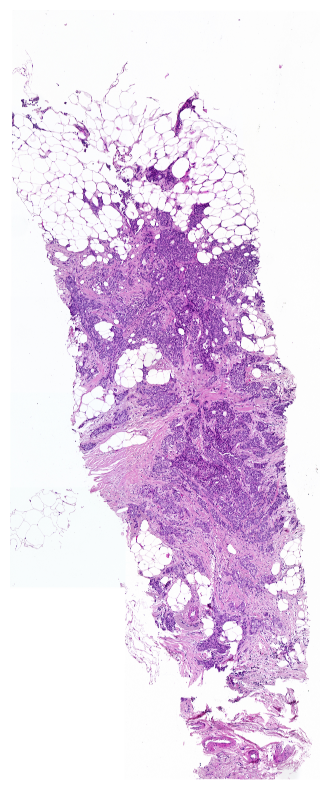

Anno:  [array([[ 26825, 117612]]), array([[ 26664, 119122]]), array([[ 28226, 114545]]), array([[ 28351, 114679]]), array([[ 28353, 116221]]), array([[ 28671, 115861]]), array([[ 28781, 115009]]), array([[ 28870, 116008]]), array([[ 29073, 118350]]), array([[ 29222, 115990]]), array([[ 29617, 118476]]), array([[ 29683, 117165]]), array([[ 28183, 120749]]), array([[ 28434, 120360]]), array([[ 28444, 120368]]), array([[ 28534, 118739]]), array([[ 28727, 119852]]), array([[ 29128, 119667]]), array([[ 29219, 119202]]), array([[ 29719, 119605]]), array([[ 29807, 119385]]), array([[ 29809, 119092]]), array([[ 29885, 119817]]), array([[ 30138, 120364]]), array([[ 30185, 119514]]), array([[ 30325, 120880]]), array([[ 29123, 123505]]), array([[ 29345, 123248]]), array([[ 30486, 122570]])]
Adjusted:  [[[1723, 7356]], [[1562, 8866]], [[3124, 4289]], [[3249, 4423]], [[3251, 5965]], [[3569, 5605]], [[3679, 4753]], [[3768, 5752]], [[3971, 8094]], [[4120, 5734]], [[4515, 8220]], [[4581, 6909]], [[308

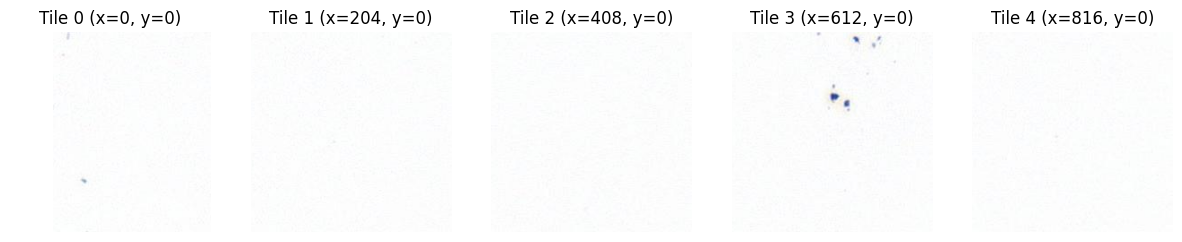

Number of tiles with tissue: 230


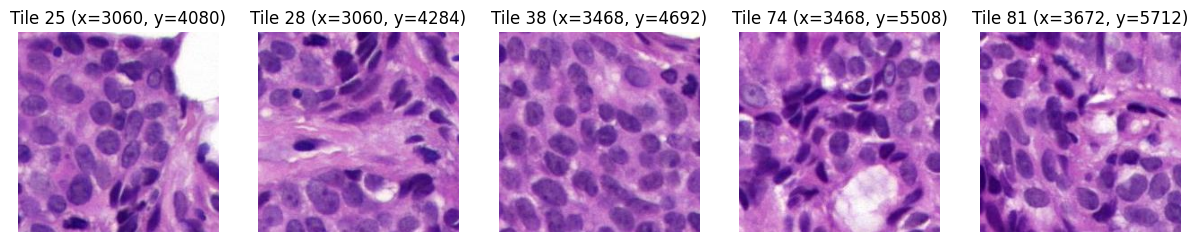

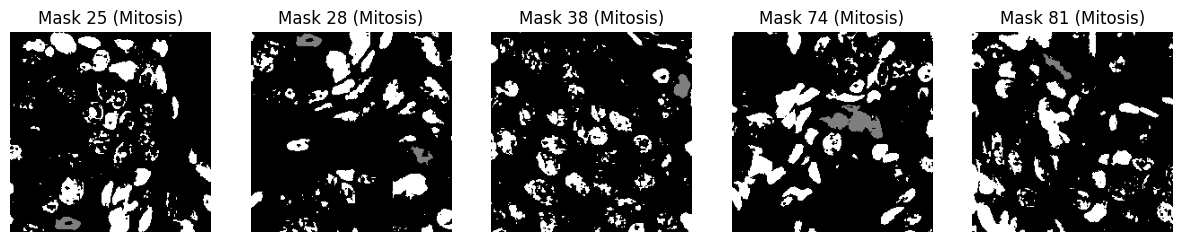

In [4]:
from PIL import Image, ImageOps
import ast
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = Image.open('WSI.jpg')

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

# Load the annotations
annotations_path = "annotations.csv"
annotations = []

with open(annotations_path, "r", newline="") as f:
    reader = csv.DictReader(f, delimiter=";")
    for line in reader:
        coords = line["coords"]
        result = np.array(ast.literal_eval(coords), dtype=int)
        annotations.append(result)

# Load the offset values
offset_path = "offset.csv"
with open(offset_path, "r", newline="") as f:
    reader = csv.DictReader(f, delimiter=";")
    offset = next(reader)
    offset_x = int(offset['x'])
    offset_y = int(offset['y'])
    
print("Anno: ", annotations)

# Adjust the annotation coordinates
adjusted_annotations = []
for annotation in annotations:
    adjusted_annotation = annotation - np.array([offset_x, offset_y])
    adjusted_annotations.append(adjusted_annotation.tolist())

# Print the adjusted coordinates
print("Adjusted: ", adjusted_annotations)
flat_list = [(sublist[0][0], sublist[0][1]) for sublist in adjusted_annotations]

print("flat :", flat_list)
# Define tile size and overlap
tile_size = 224
overlap = 20

# Function to create tiles 
def create_tiles(image, tile_size, overlap):
    tiles = []
    width, height = image.size
    step = tile_size - overlap
    for y in range(0, height - tile_size + 1, step):
        for x in range(0, width - tile_size + 1, step):
            tile = image.crop((x, y, x + tile_size, y + tile_size))
            tiles.append((x, y, tile))
    return tiles

# Generate tiles
tiles = create_tiles(image, tile_size, overlap)

# Display the number of tiles created
print(f"Number of tiles created: {len(tiles)}")

# Function to display a few tiles
def display_tiles(tiles, num_tiles=5):
    plt.figure(figsize=(15, 15))
    for i in range(num_tiles):
        x, y, tile = tiles[i]
        plt.subplot(1, num_tiles, i + 1)
        plt.imshow(tile)
        plt.title(f'Tile {i} (x={x}, y={y})')
        plt.axis('off')
    plt.show()

# Display the first 5 tiles
display_tiles(tiles, num_tiles=5)

# Define HSV range for nuclei
cell_hsvmin = (130, 70, 20)  # Broaden hue, increase min saturation to avoid pinks, keep low value
cell_hsvmax = (160, 255, 150)  # Slightly higher value to capture a bit more light

# Function to check if a tile contains tissue using HSV thresholding
def contains_tissue(tile):
    # Convert the tile to HSV color space
    hsv_tile = cv2.cvtColor(np.array(tile), cv2.COLOR_RGB2HSV)
    
    # Threshold based on HSV values
    color_thresh = cv2.inRange(hsv_tile, cell_hsvmin, cell_hsvmax)
    
    # Calculate the proportion of tissue pixels
    tissue_proportion = np.sum(color_thresh > 0) / color_thresh.size
    
    # Return True if the tissue proportion is above a certain threshold
    return tissue_proportion > 0.1  # Adjust this threshold as needed

# Filter tiles to keep only those with tissue
tissue_tiles = [(x, y, tile) for x, y, tile in tiles if contains_tissue(tile)]

# Display the number of tiles with tissue
print(f"Number of tiles with tissue: {len(tissue_tiles)}")

# Function to display selected tiles with tissue
def display_selected_tissue_tiles(tissue_tiles, tile_indices):
    plt.figure(figsize=(15, 15))
    for i, tile_index in enumerate(tile_indices):
        x, y, tile = tissue_tiles[tile_index]
        plt.subplot(1, len(tile_indices), i + 1)
        plt.imshow(tile)
        plt.title(f'Tile {tile_index} (x={x}, y={y})')
        plt.axis('off')
    plt.show()

# Display selected tiles with tissue
# You can change the indices to any other values you prefer
display_selected_tissue_tiles(tissue_tiles, tile_indices=[25, 28, 38, 74, 81])

def create_segmentation_mask(tile, tile_coords, mitosis_coords):
    tile_x, tile_y = tile_coords
    mask = np.zeros((tile_size, tile_size), dtype=np.uint8)
    
    # Convert the tile to HSV color space
    hsv_tile = cv2.cvtColor(np.array(tile), cv2.COLOR_RGB2HSV)
    
    # Threshold based on HSV values for nuclei
    nuclei_mask = cv2.inRange(hsv_tile, cell_hsvmin, cell_hsvmax)
    mask[nuclei_mask > 0] = 255  # White for nuclei
    
    contains_mitosis = False
    # Mark mitosis areas
    for mitosis in mitosis_coords:
        mit_x, mit_y = mitosis
        if tile_x <= mit_x < tile_x + tile_size and tile_y <= mit_y < tile_y + tile_size:
            local_x = mit_x - tile_x
            local_y = mit_y - tile_y
            
            if 0 <= local_x < tile_size and 0 <= local_y < tile_size:
                # Use floodFill to fill the mitosis area
                _, mitosis_mask, _, _ = cv2.floodFill(mask, None, (local_x, local_y), 127)
                contains_mitosis = True
    
    return mask, contains_mitosis


# Generate masks and store them correctly in the masks list
masks = []
for (x, y, tile) in tissue_tiles:
    mask, contains_mitosis = create_segmentation_mask(tile, (x, y), flat_list)
    masks.append((mask, contains_mitosis))  # Append as a tuple

# Function to display selected segmentation masks
def display_selected_masks(mask_data, tile_indices):
    plt.figure(figsize=(15, 15))
    for i, tile_index in enumerate(tile_indices):
        mask, contains_mitosis = mask_data[tile_index]  # Unpack the tuple
        plt.subplot(1, len(tile_indices), i + 1)
        plt.imshow(mask, cmap='gray')  # Display using grayscale to show black, gray, white
        title_text = f'Mask {tile_index}' + (" (Mitosis)" if contains_mitosis else "")
        plt.title(title_text)
        plt.axis('off')
    plt.show()

# Assuming masks is now a list of tuples (mask, contains_mitosis)
# Example mask data: [(mask1, True), (mask2, False), (mask3, True), (mask4, False), (mask5, True)]
# Display selected segmentation masks, you can adjust the indices based on where mitoses are found
tile_indices_with_mitoses = [i for i, mask_info in enumerate(masks) if mask_info[1]]
display_selected_masks(masks, tile_indices_with_mitoses[:5])  # Display the first 5 tiles containing mitoses

https://stackoverflow.com/questions/51621684/how-to-calculate-nucleus-amount-of-cell
This looks much better!
pointPolygonTest
findContour